In [24]:
import time
import os

from IPython.display import clear_output

import numpy as np
import torch
from torch import nn, optim, cuda
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


BS = 32
RESIZE = 224

In [17]:
device = 'cpu'
if cuda.is_available():
    device_name = cuda.get_device_name(0)
    memory = cuda.get_device_properties(0).total_memory / (1024 ** 3)
    print(f"Device {device_name} has {memory} GB of memory")
    device = torch.device('cuda')
else:
    raise Exception("Cuda isn't available")
device

Device NVIDIA GeForce RTX 3060 Ti has 7.9993896484375 GB of memory


device(type='cuda')

In [18]:
runs_dir = "runs"
os.makedirs(runs_dir, exist_ok=True)
existing_runs = [d for d in os.listdir(runs_dir) if os.path.isdir(os.path.join(runs_dir, d))]


if existing_runs:
    max_index = max([int(d.split("run")[1]) for d in existing_runs])
    new_run_index = max_index + 1
else:
    new_run_index = 1

current_run_dir = os.path.join(runs_dir, f"run{new_run_index}")
os.makedirs(current_run_dir, exist_ok=True)

train_stats_file = os.path.join(current_run_dir, "train_stats.txt")
test_stats_file = os.path.join(current_run_dir, "test_stats.txt")
best_model_weights_file = os.path.join(current_run_dir, "best.pth")
plot_file = os.path.join(current_run_dir, "plot.png")

In [19]:
def build_figures_with_same_x(figures, x_vals):
    n = len(figures)
    fig, axs = plt.subplots(n, 1)
    for idx, (fig_key, fig_value) in enumerate(figures.items()):
        for (plot_key, plot_value) in fig_value.items():
            # print(f"X and Y shape: {x_vals}\n{plot_value}")
            axs[idx].plot(x_vals, plot_value, label=plot_key)
        axs[idx].legend()
        axs[idx].grid(True)
        axs[idx].set_xticks(x_vals[::5])
        axs[idx].set_xticklabels(x_vals[::5], rotation=90)
        axs[idx].set_title(fig_key)

    plt.tight_layout()
    plt.show()
    plt.savefig(plot_file)

In [20]:
train_transform = transforms.Compose([
    transforms.Resize(RESIZE, antialias=False),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.CenterCrop(RESIZE),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomResizedCrop(RESIZE, antialias=False),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize(RESIZE, antialias=False),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(dtype=torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [21]:
train_dataset = datasets.ImageFolder(root='./dataset/train_small', transform=train_transform)
val_dataset = datasets.ImageFolder(root='./dataset/val', transform=val_transform)
test_dataset = datasets.ImageFolder(root='./dataset/test', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

c:\Users\kuzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input da

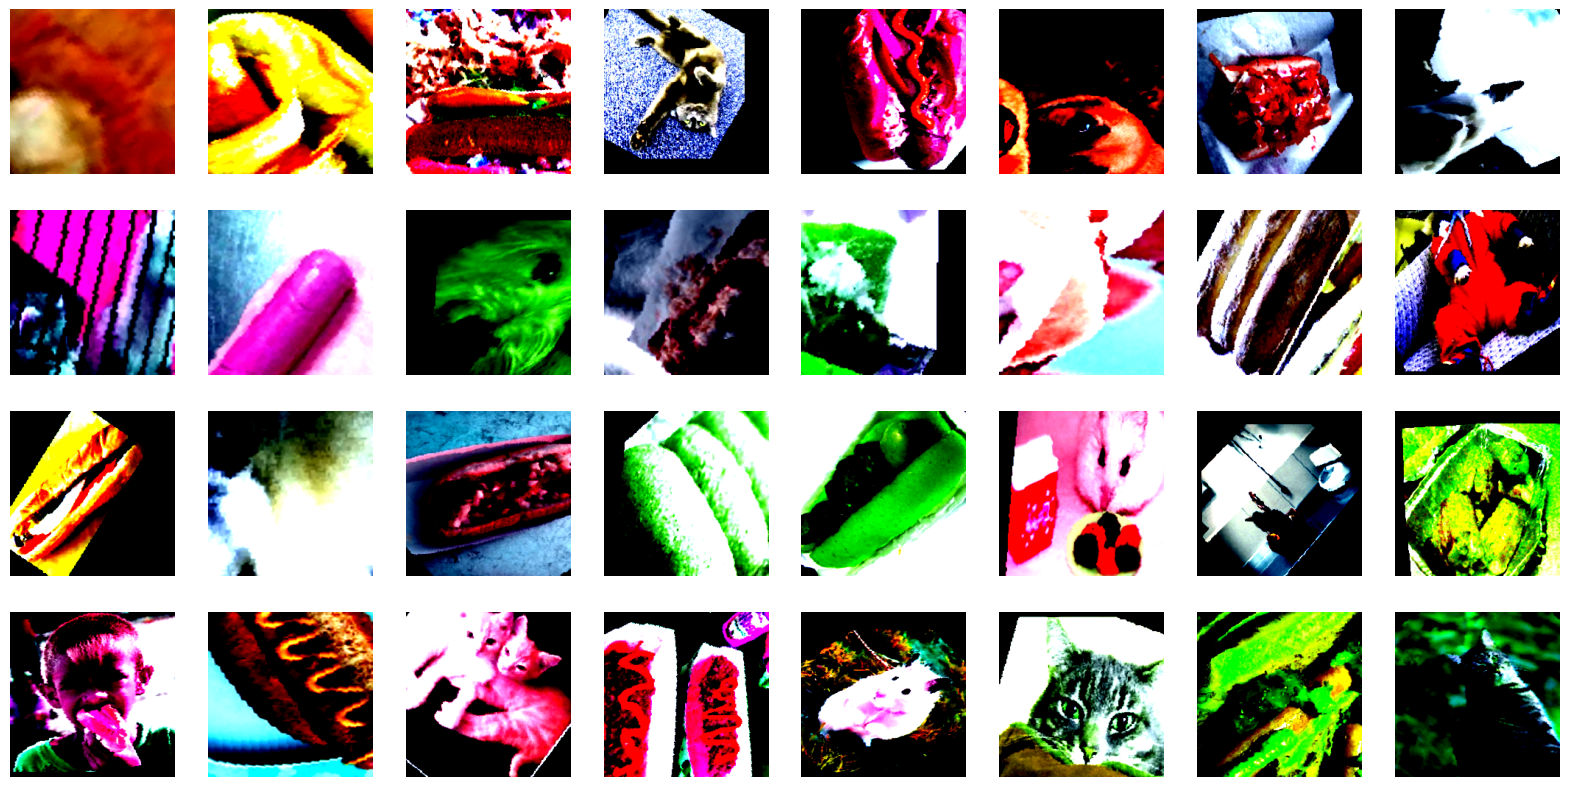

: 

In [25]:
def show_images(loader, num_images=32):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    images = images[:num_images].cpu()  # Получить первые num_images изображений и преобразовать их в CPU

    # Создать сетку для отображения изображений
    rows = int(np.ceil(num_images / 8))
    fig, axs = plt.subplots(rows, 8, figsize=(20, 10))

    for i, ax in enumerate(axs.flatten()):
        if i < len(images):
            ax.imshow(images[i].permute(1, 2, 0))
            ax.axis('off')
        else:
            ax.axis('off')  # Скрыть пустые подзаголовки, если количество изображений меньше 32

    plt.show()

# Показать изображения из train_loader
show_images(train_loader)

In [5]:
from collections import Counter

train_labels = train_dataset.targets
val_labels = val_dataset.targets
test_labels = test_dataset.targets

class_counts_train = Counter(train_labels)
class_counts_val = Counter(val_labels)
class_counts_test = Counter(test_labels)

print("Train Dataset Class Counts:")
for class_index, count in class_counts_train.items():
    class_name = train_dataset.classes[class_index]
    print(f"{class_name}: {count}")

print("Val Dataset Class Counts:")
for class_index, count in class_counts_val.items():
    class_name = val_dataset.classes[class_index]
    print(f"{class_name}: {count}")

print("Test Dataset Class Counts:")
for class_index, count in class_counts_test.items():
    class_name = test_dataset.classes[class_index]
    print(f"{class_name}: {count}")


Train Dataset Class Counts:
hotdog: 110
not hotdog: 110
Val Dataset Class Counts:
hotdog: 247
nothotdog: 247
Test Dataset Class Counts:
hotdog: 322
nothotdog: 322


In [7]:
try:
  if model:
    model.zero_grad()
    del model
    torch.cuda.empty_cache()
    print('model has been deleted')
except:
  print('model doesnt exist')

model doesnt exist


In [15]:
class CustomResNet34(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet34, self).__init__()
        self.resnet34 = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        num_features = self.resnet34.fc.in_features
        self.resnet34.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet34(x)

model = CustomResNet34(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
model

CustomResNet34(
  (resnet34): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 100
len_loader = len(train_loader)

In [11]:
x_vals = []
train_losses = []
val_losses = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

best_val_loss = float('inf')
best_val_accuracy = 0.0
best_epoch = 0

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    running_loss = 0.0
    i = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"\r Train batch {batch_idx}/{len(train_loader)}", end='', flush=True)
        i += 1
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)


def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_running_loss = 0.0
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            print(f"\r Val batch {batch_idx}/{len(val_loader)}", end='', flush=True)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)

            predicted = torch.argmax(outputs, dim=1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        epoch_val_loss = val_running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)
        f1 = f1_score(true_labels, predicted_labels)

    return (epoch_val_loss, f1)

<Figure size 640x480 with 0 Axes>

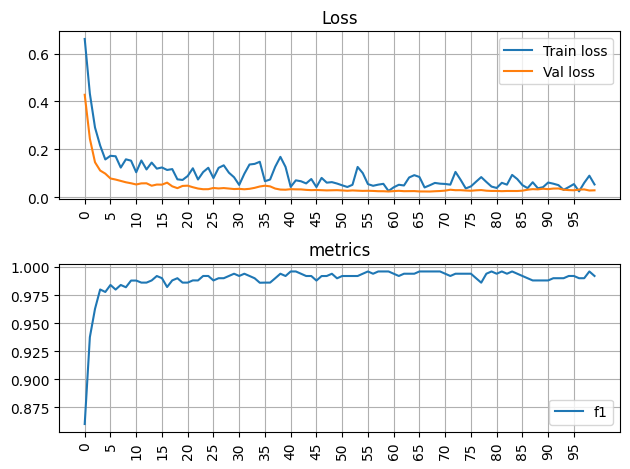

[0.6616752743721008, 0.4325983481747763, 0.29086052094187054, 0.2154390194586345, 0.15715978826795304, 0.17255140521696635, 0.1705496832728386, 0.12313857514943395, 0.15779105467455729, 0.15215734764933586, 0.10362453066876956, 0.15293041350586073, 0.11543078454477447, 0.14414377244455473, 0.11878458011363234, 0.12366503051349095, 0.11319258276905332, 0.11685391302619662, 0.07402836398354598, 0.07141671649047307, 0.08790520897933415, 0.12030680238136224, 0.07329437309609992, 0.10439466418964523, 0.12249101219432694, 0.07924344683332103, 0.12201545014977455, 0.13273869987045014, 0.10186280150498662, 0.08275326022080012, 0.050511980961476056, 0.09724760401461806, 0.1360868484313999, 0.13865753236625875, 0.1475305019744805, 0.06616254257304328, 0.07314274939043182, 0.1269220252122198, 0.1681334227323532, 0.1259844010429723, 0.04233577301991837, 0.0697673601763589, 0.06589316576719284, 0.05689688931618418, 0.07531465137643474, 0.04155554569193295, 0.08007751085928508, 0.060093882892813, 0.

<Figure size 640x480 with 0 Axes>

In [12]:
start = time.time()
for epoch in range(num_epochs):
    print(f'\rEpoch: {epoch} / {num_epochs}')
    x_vals.append(epoch)


    epoch_train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"\nTrain loss: {epoch_train_loss}")
    train_losses.append(epoch_train_loss)


    epoch_val_loss, f1 = val_epoch(model, val_loader, criterion, device)
    f1_list.append(f1)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_val_f1 = f1
        best_epoch = epoch
        torch.save(model.state_dict(), best_model_weights_file)
        dur = time.time() - start
        with open(train_stats_file, "a") as f:
            f.write(f"Epoch {epoch + 1} / {num_epochs}: Train Loss: {epoch_train_loss}, Val Loss: {epoch_val_loss}, Val f1: {f1} Dur: {dur} Dur/Epoch: {dur / epoch if epoch != 0 else 0}\n")
    elif epoch > best_epoch + (num_epochs // 2):
        print(f"\nTraining has stopped at {epoch} / {num_epochs} cuz val loss didn't decrease for {num_epochs // 2} epochs")
        break


    clear_output(wait=True)
    build_figures_with_same_x({'Loss': {'Train loss': train_losses, 'Val loss': val_losses}, 'metrics': {'f1': f1_list}}, x_vals)
    print(train_losses)
    print(val_losses)
    print(f"f1: {f1}")


In [13]:
# torch.save(model.state_dict(), os.path.join(current_run_dir, "last.pth"))
# exit()
# model = models.resnet34()
# num_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 1),
#     nn.Sigmoid()
# )
best_model_weights_file = r'C:\Users\kuzga\OneDrive\Рабочий стол\sem4\hotdog_nothotdog\runs\run38\best.pth'
# model.load_state_dict(torch.load(best_model_weights_file))
# model = model.to(device)


TP = 0
FP = 0
TN = 0
FN = 0


model.eval()
running_loss = 0.0

with torch.no_grad():
  for batch_idx, (images, labels) in enumerate(test_loader):
    print(f"\rBatch {batch_idx}/{len(test_loader)}", end='', flush=True)
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    predicted = torch.argmax(outputs, dim=1)


    TP += ((predicted == 1) & (labels == 1)).sum().item()
    FP += ((predicted == 1) & (labels == 0)).sum().item()
    TN += ((predicted == 0) & (labels == 0)).sum().item()
    FN += ((predicted == 0) & (labels == 1)).sum().item()

    test_acc = (TP + TN) / (TP + FP + TN + FN)
    test_pres = TP / (TP + FP) if (TP + FP) > 0 else 0
    test_rec = TP / (TP + FN) if (TP + FN) > 0 else 0
    test_f1 = 2 * (my_precision * my_recall) / (my_precision + my_recall) if (my_precision + my_recall) > 0 else 0

  test_loss = running_loss / len(test_dataset)

print()
res_str = f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, Test Precision: {test_pres:.4f}, Test Recall: {test_rec:.4f}, Test F1-score: {test_f1:.4f}"
print(res_str)
with open(test_stats_file, "a") as f:
  f.write(res_str)

Batch 0/21

c:\Users\kuzga\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:488: UserWarning: Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.
  warnings.warn("Anti-alias option is always applied for PIL Image input. Argument antialias is ignored.")


NameError: name 'my_precision' is not defined

In [ ]:
#10 epochs: Test Loss: 0.2050, Test Accuracy: 0.9193, Test Precision: 0.5031, Test Recall: 0.4503, Test F1-score: 0.4696
#50 epochs: Test Loss: 0.2354, Test Accuracy: 0.9022, Test Precision: 0.5031, Test Recall: 0.4379, Test F1-score: 0.4616